# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup, train and deploy your model. This notebook will show how to run the Argo jobs and example prediction calls to the deployed models.

**To run this notebook you will need to install Tensorflow**
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

# Setup

Set kubectl to use the namespace where you installed kubeflow and seldon. In the README it is kubeflow-seldon

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=kubeflow-seldon

Context "gke_seldon-deploy_europe-west1-b_cluster-1" modified.


# Mnist Setup
You will need Tensorflow installed to run this section.

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

/home/clive/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


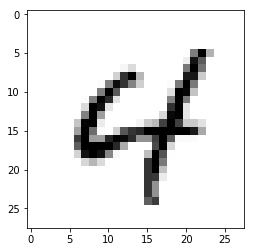

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

Create proto files for gRPC. You will need [python grpc tools](https://grpc.io/docs/quickstart/python.html) installed

In [10]:
!python -m grpc.tools.protoc -I. --python_out=. --grpc_python_out=. ./proto/prediction.proto

In [11]:
import requests
from requests.auth import HTTPBasicAuth
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json
from visualizer import get_graph

AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print(response.status_code)
    return response.json()   

def grpc_request(deploymentName,data):
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print(response)

def send_feedback_rest(deploymentName,request,response,reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    ret = requests.post(
         "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/feedback",
        json=feedback)
    return ret.text


# Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n default -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:80
```

If the tensorflow model has not been deployed you can directly use the kubernetes manifest for it to deploy

In [12]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" created


#### REST Request

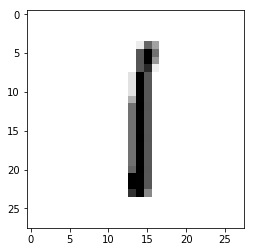

{
  "meta": {
    "puid": "gei4vgtefe7mqpdu2mmcr21dls",
    "tags": {},
    "routing": {}
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6",
      "class:7",
      "class:8",
      "class:9"
    ],
    "ndarray": [
      [
        1.361524027743144e-06,
        0.9898567199707031,
        0.0013239487307146192,
        0.003329393919557333,
        3.0935349059291184e-05,
        0.0008889648015610874,
        0.0006419408018700778,
        0.00033004060969688,
        0.003166917245835066,
        0.00042977629345841706
      ]
    ]
  }
}


In [12]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

gRPC Request

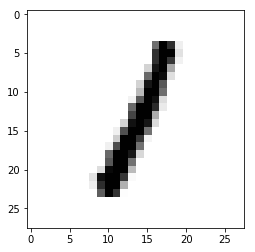

meta {
  puid: "q8imm2ps47jc8oc8u8vtee6cuv"
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  tensor {
    shape: 1
    shape: 10
    values: 1.9245564999437192e-06
    values: 0.9849417209625244
    values: 0.011671005748212337
    values: 0.0006085013737902045
    values: 2.674031293281587e-06
    values: 0.00011305740918032825
    values: 0.0002356159093324095
    values: 2.78427960438421e-05
    values: 0.0023623150773346424
    values: 3.532939444994554e-05
  }
}



In [13]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((784))
grpc_request("mnist-classifier",data)

# Next Steps
seldon-core can deploy complex runtime graphs. We'll illustrate two below by training a second model using scikit-learn.

In [14]:
!argo submit ../workflows/training-sk-mnist-workflow.yaml

Name:             kubeflow-sk-train-l7qlr
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Mar 27 16:14:05 +0100 (now)
Parameters:       
  version:        0.1
  github-user:    kubeflow
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


In [17]:
!argo list

NAME                      STATUS      AGE    DURATION
kubeflow-sk-train-l7qlr   Succeeded   4m     1m 
seldon-tf-deploy-jg8ns    Succeeded   15m    2s 
kubeflow-tf-train-qsnkf   Succeeded   4h     58s 


In [18]:
!argo submit ../workflows/serving-sk-mnist-workflow.yaml

Name:             seldon-sk-deploy-468tn
Namespace:        kubeflow-seldon
ServiceAccount:   default
Status:           Pending
Created:          Tue Mar 27 16:19:13 +0100 (now)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  github-revision: master
  docker-user:    seldonio
  build-push-image: false


In [19]:
!argo list

NAME                      STATUS      AGE    DURATION
seldon-sk-deploy-468tn    Succeeded   2m     2s 
kubeflow-sk-train-l7qlr   Succeeded   7m     1m 
seldon-tf-deploy-jg8ns    Succeeded   18m    2s 
kubeflow-tf-train-qsnkf   Succeeded   4h     58s 


## AB Test
 Run an AB Test between Tensorflow model and SKLearn Random Forest.
 

In [20]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

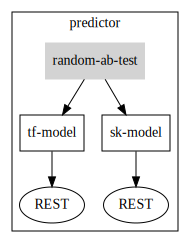

In [21]:
get_graph("../k8s_serving/ab_test_sklearn_tensorflow.json",'r')

In [22]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [24]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

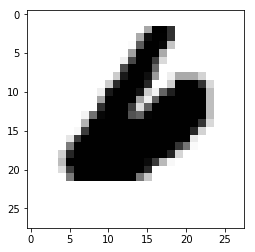

{
  "meta": {
    "puid": "hnr95hejc2il3vr102b52tj291",
    "tags": {},
    "routing": {
      "random-ab-test": 1
    }
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6",
      "class:7",
      "class:8",
      "class:9"
    ],
    "ndarray": [
      [
        0.0,
        0.06666666666666667,
        0.1,
        0.0,
        0.1,
        0.3,
        0.06666666666666667,
        0.2,
        0.1,
        0.06666666666666667
      ]
    ]
  }
}


In [25]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


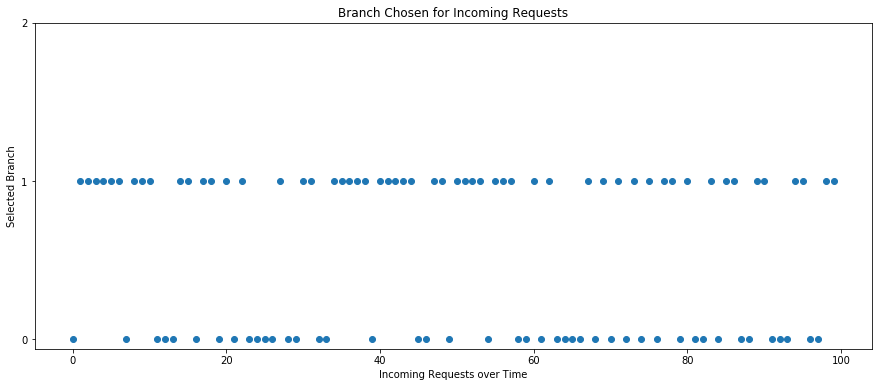

In [27]:
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print("{}/{}".format(idx,sz))
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("random-ab-test")
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")

## Multi-Armed Bandit
Run a e-greey multi-armed bandit to push traffic to best performing model.

In [28]:
!pygmentize ../k8s_serving/epsilon_greedy.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

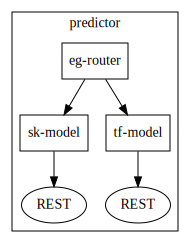

In [29]:
get_graph("../k8s_serving/epsilon_greedy.json",'r')

In [30]:
!kubectl apply -f ../k8s_serving/epsilon_greedy.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [32]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[replicasAvailable:1 name:mnist-classifier-mnist-classifier replicas:1]]]

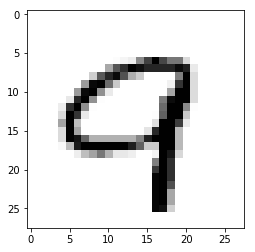

{
  "meta": {
    "puid": "pmhq0d9c8sbkmdo648dpg6t4tp",
    "tags": {},
    "routing": {
      "eg-router": 0
    }
  },
  "data": {
    "names": [
      "class:0",
      "class:1",
      "class:2",
      "class:3",
      "class:4",
      "class:5",
      "class:6",
      "class:7",
      "class:8",
      "class:9"
    ],
    "ndarray": [
      [
        0.03333333333333333,
        0.16666666666666666,
        0.06666666666666667,
        0.03333333333333333,
        0.13333333333333333,
        0.03333333333333333,
        0.0,
        0.43333333333333335,
        0.03333333333333333,
        0.06666666666666667
      ]
    ]
  }
}


In [34]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
[3.0, 74.0]


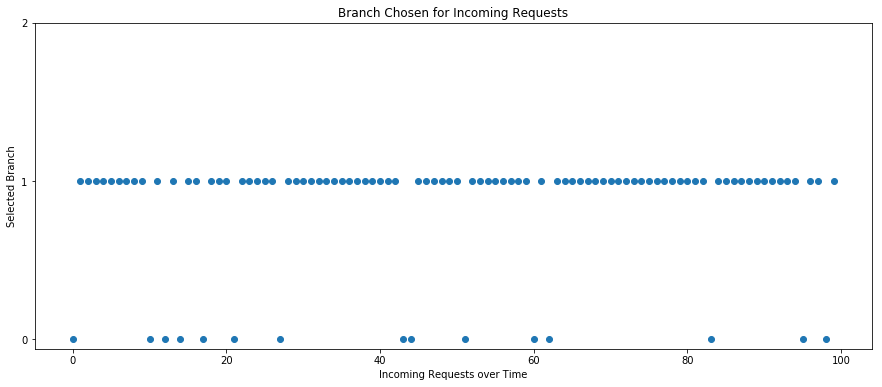

In [35]:
score = [0.0,0.0]
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print("{}/{}".format(idx,sz))
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("eg-router")
    proba = response["data"]["ndarray"][0]
    predicted = proba.index(max(proba))
    correct = np.argmax(batch_ys[idx])
    if predicted == correct:
        score[route] = score[route] + 1
        send_feedback_rest("mnist-classifier",request,response,reward=1)
    else:
        send_feedback_rest("mnist-classifier",request,response,reward=0)
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")
print(score)